# Part 1 - Downloading a sample youtube video

## Install necessary packages

In [2]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00


## Import and define function

In [3]:
import pytube

def download_youtube_video(video_url, download_path):
  """Downloads a YouTube video to a specified path.

  Args:
    video_url: The URL of the YouTube video to download.
    download_path: The path to save the downloaded video to.
  """

  # Create a YouTube object from the video URL.
  yt = pytube.YouTube(video_url)

  # Get the highest quality stream of the video.
  stream = yt.streams.get_highest_resolution()

  # Download the video to the specified path.
  stream.download(download_path)

  # Return the path to the downloaded video.
  return download_path

In [7]:
!ffmpeg -ss 0 -i video_1.mp4 -c copy -t 30 output.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Download video

Use previously defined function to download video from youtube. Make sure to rename the video or update the function in the next part(extract thumbnails) to use your chosen name.

In [4]:
video_url = "https://www.youtube.com/watch?v=dQw4w9WgXcQ"
download_path = "."

downloaded_video_path = download_youtube_video(video_url, download_path)

print("Downloaded video to:", downloaded_video_path)

Downloaded video to: .


# Part 2 - Extract Thumbnails

This function converts a video into individual picture frames, allowing you to specify the desired number. It automatically calculates the video's frame rate to evenly capture frames. This section could be enhanced by implementing a smarter method of detecting key frames out of the video.

In [8]:
import os
import cv2
import moviepy.editor as mp
import requests
import json

# Function to extract frames from the video and save them as thumbnails
def extract_frames(video_file, output_folder, num_frames):
    clip = mp.VideoFileClip(video_file)
    frame_rate = clip.fps
    duration = clip.duration
    interval = duration / num_frames

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i in range(num_frames):
        time = i * interval
        frame = clip.get_frame(time)
        thumbnail_path = os.path.join(output_folder, f"frame_{i}.jpg")
        cv2.imwrite(thumbnail_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    return [os.path.join(output_folder, f"frame_{i}.jpg") for i in range(num_frames)]

if __name__ == "__main__":
    video_file = 'output.mp4'
    output_folder = './thumbnails'
    num_frames = 10  # Number of frames/thumbnails to generate

    # Extract frames from the video
    image_paths = extract_frames(video_file, output_folder, num_frames)


# Part 3 - Use Visual GPT to generate descriptions

Download visual gpt

In [ ]:
!rm -rf TaskMatrix && git clone https://github.com/microsoft/TaskMatrix

Cloning into 'TaskMatrix'...
remote: Enumerating objects: 585, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 585 (delta 129), reused 111 (delta 110), pack-reused 419
Receiving objects: 100% (585/585), 40.23 MiB | 7.55 MiB/s, done.
Resolving deltas: 100% (224/224), done.


Go to directory


In [ ]:
cd /content/TaskMatrix/

/content/TaskMatrix


Install packages


In [ ]:
!pip install -r requirements.txt
!pip install git+https://github.com/IDEA-Research/GroundingDINO.git
!pip install git+https://github.com/facebookresearch/segment-anything.git

Fetch Open AI Key from Google Drive

**Note:** You should use your own Open AI API key for this to work

In [9]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/Hidden-API/openai_key.txt'
with open(file_path, 'r') as file:
  api_key = file.read().strip()

Mounted at /content/drive


Set your OPENAI_API_KEY


In [ ]:
%env OPENAI_API_KEY=$api_key

Install dependencies

In [ ]:
!pip install mediapipe pytube transformers

Import dependencies

In [ ]:
from visual_chatgpt import *

In [ ]:
!mkdir -p checkpoints

def generate_description(img):
  # load = "ImageCaptioning_cuda:0,Text2Image_cuda:0"
  #load = "Text2Box_cuda:0,Segmenting_cuda:0,Inpainting_cuda:0,ImageCaptioning_cuda:0"
  load = "ImageCaptioning_cuda:0"
  load_dict = {e.split('_')[0].strip(): e.split('_')[1].strip() for e in load.split(',')}

  bot = ConversationBot(load_dict=load_dict)
  state = []

  bot.init_agent('English')
  bot.run_image(img, state, '', 'English')
  bot.run_text('Describe the image as vividly as possible in no more than 2 paragraphs', state)

  output = bot.memory.buffer
  bot.memory.clear()
  return output.split('\n')[-1].split(':')[-1].strip()


Run VisualChatGPT

In [ ]:
import os
# assign directory
directory = '/content/thumbnails'
desc_file = '/content/descriptions.txt'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f'Generating descriptions for {f}')
        d = generate_description(f)
        with open(desc_file, "a") as a_file:
          a_file.write(d)
          a_file.write("\n")

Generating descriptions for /content/thumbnails/frame_7.jpg
Initializing VisualChatGPT, load_dict={'ImageCaptioning': 'cuda:0'}
Initializing ImageCaptioning to cuda:0
All the Available Functions: {'ImageCaptioning': <visual_chatgpt.ImageCaptioning object at 0x7ce3c2c6f190>}
======>Auto Resize Image...
Resize image form 1280x720 to 512x256


/usr/local/lib/python3.10/dist-packages/gradio/helpers.py:818: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Textbox(...)` instead of `return gr.update(...)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(



Processed ImageCaptioning, Input Image: image/85a17d91.png, Output Text: a man with a microphone in his mouth

Processed run_image, Input image: image/85a17d91.png
Current state: [('![](file=image/85a17d91.png)*image/85a17d91.png*', 'Received.  ')]
Current Memory: 
Human: provide a figure named image/85a17d91.png. The description is: a man with a microphone in his mouth. This information helps you to understand this image, but you should use tools to finish following tasks, rather than directly imagine from my description. If you understand, say "Received". 
AI: Received.  
history_memory:
Human: provide a figure named image/85a17d91.png. The description is: a man with a microphone in his mouth. This information helps you to understand this image, but you should use tools to finish following tasks, rather than directly imagine from my description. If you understand, say "Received". 
AI: Received.  , n_tokens: 48


> Entering new AgentExecutor chain...
Action: Get Photo Description
Act

# Part 4 - Generate Summary Video

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [14]:
import openai

In [ ]:
print(descriptions)

The image shows a man with a microphone in his mouth. He is wearing a black t-shirt and blue jeans, and has a pair of black headphones around his neck. His eyes are closed and his mouth is slightly open, as if he is singing or speaking. He appears to be in a studio or on a stage, as there is a bright light shining down on him. He looks relaxed and confident, as if he is ready to perform.
The image shows a man in a white coat dancing. He is wearing a white coat with a black belt and black shoes. His arms are outstretched and he is smiling. He appears to be in a joyful mood, as if he is enjoying the music he is dancing to. He is standing on a wooden floor, with a white wall behind him. The lighting is soft and warm, giving the image a cozy and inviting atmosphere.
The image shows a man with a prominent nose on his face. He has a strong jawline and a determined expression. His eyes are focused and his mouth is slightly open, as if he is about to say something. He is wearing a white shirt 

In [15]:
# Read the desctiptions provided from file
file = open("/content/drive/MyDrive/Colab Notebooks/Hidden-API/desc_bk.txt", "r")
descriptions = file.read()
file.close()

# Generate summary
response = openai.ChatCompletion.create(
  model="gpt-4",
  messages=[{
      "role": "user",
      "content": "Given the following descriptions, which describe different frames taken from a video, rewrite those descriptions into a single prompt that is to be used in a text-to-image generator: {}".format(descriptions)
  }]
)

In [18]:
print(response.choices[0].message.content)

The image depicts various frames capturing different scenes: a man with a microphone in his mouth, a man in a white coat dancing, a man with a prominent nose and a determined expression, a young boy joyfully jumping on a fence, a couple standing in a church sharing a moment of joy, a man in a suit singing into a microphone, a man singing into a microphone with a guitar strapped to his back, a black image with a white border creating mystery, a man in a white jacket laughing with pure joy, and a man in a white jacket standing in front of a graffiti-covered brick wall with a serious expression. Capture the essence of these frames and create a single prompt for the text-to-image generator.


# Generate Image

In [19]:
gen_img = openai.Image.create(
  prompt=response.choices[0].message.content,
  n=1,
  size="1024x1024"
)
image_url = gen_img['data'][0]['url']

In [23]:
print(image_url)
import requests

img_data = requests.get(image_url).content
with open('image_name.jpg', 'wb') as handler:
    handler.write(img_data)

https://oaidalleapiprodscus.blob.core.windows.net/private/org-N7x5XgCqv0qrwQCta4KoqcG2/user-v6rgbTdieQVaMAaPxJ5ibPAE/img-Wq1f5aNqW7NmJTM7blz5GYvi.png?st=2023-10-19T12%3A27%3A35Z&se=2023-10-19T14%3A27%3A35Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2023-10-18T20%3A05%3A12Z&ske=2023-10-19T20%3A05%3A12Z&sks=b&skv=2021-08-06&sig=NNlWKtEQJwD2i/Xm1XXsbacE3LyEl2OX3JL26529JDc%3D


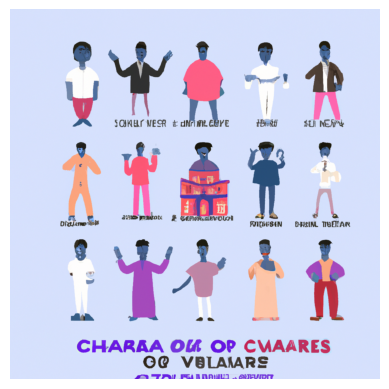

In [26]:
import cv2
from matplotlib import pyplot as plt
img_unchanged = cv2.imread('./image_name.jpg',-1)
plt.imshow(img_unchanged)
plt.axis("off")
plt.show()